Using torch ML library for GPU utilisation

Boltzmann distribution, simulation of particles after colliding for an extended period of time they reach the boltzmann distribution

In [23]:
%pip install torch
%pip install scienceplots

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [24]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Define number of particles and get random positions (between 0 and 1) for each particle


In [25]:
n_particles = 16
r = torch.rand((2, n_particles)).to(device)

In [26]:
r # tensor can live on graphics card

tensor([[0.4032, 0.1755, 0.0611, 0.3238, 0.4464, 0.9659, 0.5894, 0.4284, 0.8574,
         0.2593, 0.7248, 0.1619, 0.6450, 0.7482, 0.5165, 0.9752],
        [0.8702, 0.3430, 0.0230, 0.4116, 0.7206, 0.9362, 0.7005, 0.2499, 0.4294,
         0.9593, 0.4656, 0.1963, 0.0227, 0.9769, 0.1003, 0.4672]],
       device='cuda:0')

In [27]:
n_particles = 16
# uniform distribution of particles in square r \in [0, 1]
r = torch.rand((2, n_particles)).to(device) # here we send it to GPU

# Color particles the start on either side
ixr = r[0]>0.5 #right
ixl = r[0]<= 0.5 #left

Give IDs to each particle (this will come in handy later)

In [28]:
ids = torch.arange(n_particles) # analogous to np.arange()

Plot initial configuration of particles

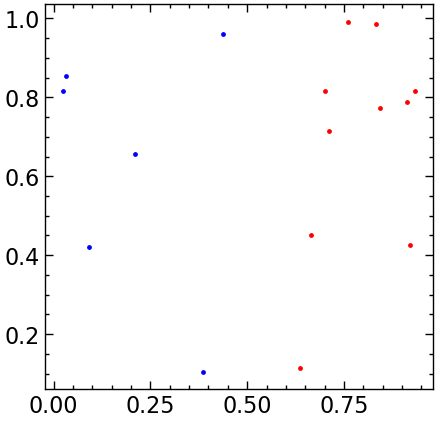

In [29]:
plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr].cpu(), r[1][ixr].cpu(), color='r', s=6)
plt.scatter(r[0][ixl].cpu(), r[1][ixl].cpu(), color='b', s=6)
# here in torch we need to switch to CPU if we want to plot

Obtain the initial velocities in the gas. We'll make the particles starting on the RHS move to the left at 500m/s and on the vice versa.
* **Note**: We're using the assumption that particles in a gas move at approximately 500m/s, thanks google.

In [30]:
v = torch.zeros((2, n_particles)).to(device)
v.shape
# v[0] - the X velocity of all particles
v[0][ixr] = -500  # desni grejo v levo
v[0][ixl] = 500  # levi grejo v desno (it's a mask for the direction)
# every pytorch function is analogous to numpy, really handy


To run this simulation, we need to determine when two particles collid, and what the resulting final velocities will be.

# Part 1: Distance Between all Pairs

* To determine if two particles collide, we need to find the distance between **all pairs** of particles. If the distance is less than 2 times the radius of each particle, they collide. If there are *n* particles, there are $n(n-1)/2$ pairs (combinatorics). To make this easier, we'll get pairs of particle IDs.

In [31]:
ids_pairs = torch.combinations(ids, 2).to(device)
ids_pairs  # 120 pairs for 16 particles, this is why it gets expensive

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0,  9],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 14],
        [ 0, 15],
        [ 1,  2],
        [ 1,  3],
        [ 1,  4],
        [ 1,  5],
        [ 1,  6],
        [ 1,  7],
        [ 1,  8],
        [ 1,  9],
        [ 1, 10],
        [ 1, 11],
        [ 1, 12],
        [ 1, 13],
        [ 1, 14],
        [ 1, 15],
        [ 2,  3],
        [ 2,  4],
        [ 2,  5],
        [ 2,  6],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 10],
        [ 2, 11],
        [ 2, 12],
        [ 2, 13],
        [ 2, 14],
        [ 2, 15],
        [ 3,  4],
        [ 3,  5],
        [ 3,  6],
        [ 3,  7],
        [ 3,  8],
        [ 3,  9],
        [ 3, 10],
        [ 3, 11],
        [ 3, 12],
        [ 3, 13],
        [ 3, 14],
        [ 3, 15],
        [ 4,  5],
        [ 

We can obtain distances between particles in a similar fashion
* First get the pairs of x-positions of all particles

In [32]:
x_pairs = torch.combinations(r[0], 2).to(device)
x_pairs

tensor([[0.6367, 0.7121],
        [0.6367, 0.8317],
        [0.6367, 0.0915],
        [0.6367, 0.6650],
        [0.6367, 0.2090],
        [0.6367, 0.0308],
        [0.6367, 0.7004],
        [0.6367, 0.3846],
        [0.6367, 0.7604],
        [0.6367, 0.4376],
        [0.6367, 0.8420],
        [0.6367, 0.9139],
        [0.6367, 0.9205],
        [0.6367, 0.9337],
        [0.6367, 0.0234],
        [0.7121, 0.8317],
        [0.7121, 0.0915],
        [0.7121, 0.6650],
        [0.7121, 0.2090],
        [0.7121, 0.0308],
        [0.7121, 0.7004],
        [0.7121, 0.3846],
        [0.7121, 0.7604],
        [0.7121, 0.4376],
        [0.7121, 0.8420],
        [0.7121, 0.9139],
        [0.7121, 0.9205],
        [0.7121, 0.9337],
        [0.7121, 0.0234],
        [0.8317, 0.0915],
        [0.8317, 0.6650],
        [0.8317, 0.2090],
        [0.8317, 0.0308],
        [0.8317, 0.7004],
        [0.8317, 0.3846],
        [0.8317, 0.7604],
        [0.8317, 0.4376],
        [0.8317, 0.8420],
        [0.8

* Then take the difference to get $\Delta x_{ij}$ of all pairs

In [33]:
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
# gives distance between all pairs v oklepajih, 
#  .ravel() unravels it into a 1D array/tensor
dx_pairs

tensor([ 0.0754,  0.1950, -0.5452,  0.0283, -0.4277, -0.6060,  0.0637, -0.2521,
         0.1236, -0.1991,  0.2053,  0.2772,  0.2837,  0.2969, -0.6133,  0.1196,
        -0.6206, -0.0471, -0.5031, -0.6813, -0.0116, -0.3275,  0.0483, -0.2745,
         0.1300,  0.2019,  0.2084,  0.2216, -0.6887, -0.7402, -0.1667, -0.6227,
        -0.8010, -0.1313, -0.4471, -0.0714, -0.3941,  0.0103,  0.0822,  0.0887,
         0.1019, -0.8083,  0.5735,  0.1175, -0.0607,  0.6090,  0.2931,  0.6689,
         0.3461,  0.7506,  0.8225,  0.8290,  0.8422, -0.0681, -0.4561, -0.6343,
         0.0354, -0.2804,  0.0953, -0.2274,  0.1770,  0.2489,  0.2554,  0.2686,
        -0.6416, -0.1782,  0.4915,  0.1757,  0.5514,  0.2286,  0.6331,  0.7050,
         0.7115,  0.7247, -0.1856,  0.6697,  0.3539,  0.7296,  0.4068,  0.8113,
         0.8832,  0.8897,  0.9029, -0.0074, -0.3158,  0.0599, -0.2629,  0.1416,
         0.2135,  0.2200,  0.2332, -0.6770,  0.3757,  0.0530,  0.4574,  0.5293,
         0.5358,  0.5490, -0.3612, -0.32

The total distance is just $d_{ij} = \sqrt{\Delta x_{ij}^{2} + \Delta y_{ij}^2}$. Since there are $n(n-1)/2$ pairs, there will be $n(n-1)/2$ different values of $d_{ij}$.

In [34]:
x_pairs = torch.combinations(r[0], 2).to(device)
y_pairs = torch.combinations(r[1], 2).to(device)
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dy_pairs = torch.diff(y_pairs, axis=1).ravel()
d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)
# these distances correspond to the ids_pairs, we look at these distances
#  at each step of the simulation/iteration
d_pairs

tensor([0.6052, 0.8932, 0.6260, 0.3397, 0.6909, 0.9569, 0.7060, 0.2522, 0.8870,
        0.8706, 0.6901, 0.7298, 0.4224, 0.7622, 0.9323, 0.2964, 0.6863, 0.2661,
        0.5064, 0.6956, 0.1034, 0.6916, 0.2821, 0.3694, 0.1425, 0.2152, 0.3551,
        0.2437, 0.6961, 0.9307, 0.5585, 0.7044, 0.8116, 0.2136, 0.9874, 0.0717,
        0.3949, 0.2130, 0.2130, 0.5658, 0.1979, 0.8259, 0.5744, 0.2628, 0.4373,
        0.7262, 0.4312, 0.8794, 0.6415, 0.8287, 0.9009, 0.8290, 0.9300, 0.4005,
        0.4996, 0.7510, 0.3663, 0.4463, 0.5482, 0.5575, 0.3660, 0.4186, 0.2567,
        0.4519, 0.7375, 0.2664, 0.5171, 0.5786, 0.6456, 0.3812, 0.6437, 0.7173,
        0.7476, 0.7420, 0.2447, 0.6707, 0.8287, 0.7425, 0.4207, 0.8154, 0.8856,
        0.9872, 0.9037, 0.0392, 0.7788, 0.1852, 0.2999, 0.1484, 0.2153, 0.4480,
        0.2332, 0.6770, 0.9634, 0.8579, 0.8093, 0.8648, 0.6249, 0.8980, 0.7973,
        0.3242, 0.2342, 0.2548, 0.5878, 0.2473, 0.7577, 0.4463, 0.5066, 0.7205,
        0.5170, 0.4390, 0.0737, 0.3548, 

# Part 2: Velocities of a Collision

So at each iteration of the simulation, we will evaluate `d_pairs`, and if any of the distances between particles is less than $2r$, then a collision occurs. What is the final velocity of each of the two spheres? In an elastic collision (conservation of energy + momentum + angular momentum), one can show

$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

In [35]:
radius = 0.06 # quite large this is bad for gas
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]
ids_pairs_collide

tensor([[ 1,  7],
        [ 2,  9],
        [ 6, 15],
        [11, 12],
        [11, 14],
        [12, 14]], device='cuda:0')

In [36]:
v1 = v[:, ids_pairs_collide[:, 0]]
v2 = v[:, ids_pairs_collide[:, 1]]
r1 = r[:, ids_pairs_collide[:, 0]]
r2 = r[:, ids_pairs_collide[:, 1]]


Then we can compute the new velocity:

In [37]:
v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)

# I think I can do this better
#v1new = v1 - torch.dot((v1-v2), (r1-r2))/torch.dot((r1-r2), (r1-r2)) * (r1-r2)
#v2new = v2 - torch.dot((v1-v2), (r1-r2))/torch.dot((r2-r1), (r2-r1)) * (r2-r1)
# lmao naah it dont work ker niso 1D tensors

# Part 3: Functions to Run the Simulation

Here we define some functions that will help make running the simulation easier.

In [49]:
def get_deltad_pairs(r):
    dx = torch.diff(torch.combinations(r[0],2).to(device)).squeeze()
    dy = torch.diff(torch.combinations(r[1],2).to(device)).squeeze()
    return torch.sqrt(dx**2 + dy**2)

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    # every iteration
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = id_pairs[get_deltad_pairs(r) < d_cutoff]
        # id's of colliding pairs
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]],
                                                   r[:,ic[:,0]], r[:,ic[:,1]])
        # setting the velocities to new velocities where they collid
        
        # adjusting if they hit the sides of the box
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        # "integrating"
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs

Set the radius and find the position of all particles as function of time (3D array `rs` where each axis is $(t, x, y)$).

In [50]:
radius = 0.03
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=8e-6, d_cutoff=2*radius)

# Here's where the use of GPU comes into play
#  for small number of particles running it on the GPU will be costlier
#  due to the overhead of running on GPU, but for more particels its essential

# the CPU one runs 1.0s for 16 particles and the GPU one 10.0s...

Plot red and blue circles, making sure each is the correct size.

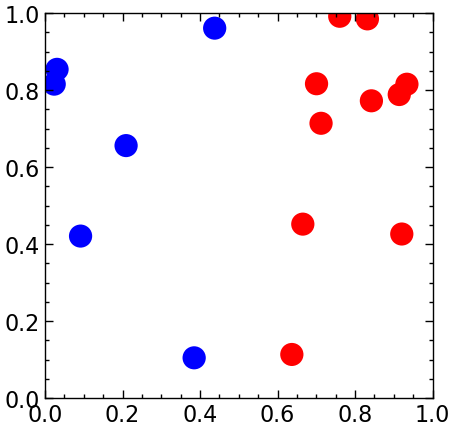

In [51]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl], rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred, yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue, yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Make initial animation of the simulation

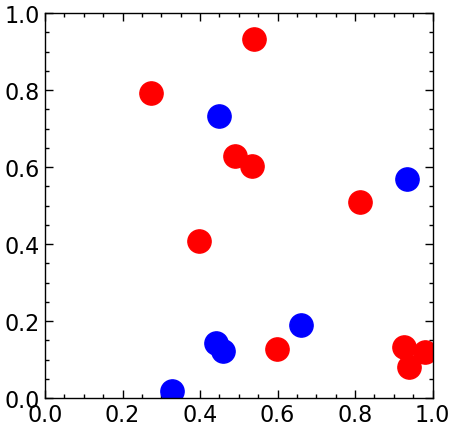

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.clear()
vmin = 0
vmax = 1
ax.set_xlim(0,1)
ax.set_ylim(0,1)
markersize = 2*radius *ax.get_window_extent().width / (vmax-vmin) *72./fig.dpi
red, = ax.plot([], [], 'o', color='red', markersize=markersize)
blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(), rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani3.mp4', writer=writer, dpi=100)

# This is a much better animation plotting script, it uses `blit`,
#  blit is an optimisation technique that only redraws the things that have changed
#  so in this case only the positions of particles, not the axes are redrawn
# it makes quite a large difference with big animations

Now that we're sure that it work, lets make a simulation containing many more particles

In [59]:
n_particles = 10000
r = torch.rand((2, n_particles)).to(device)
ixr = r[0]>0.5
ixl = r[0]<= 0.5
ids = torch.arange(n_particles)
ids_pairs = torch.combinations(ids, 2).to(device)
v = torch.zeros((2, n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500
radius = 0.0015
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=8e-6, d_cutoff=2*radius)

Let's look at the final velocity distribution of the particles and compare it to Maxwell-Boltzmann in 2 Dimensions:

* $kT = KE_{avg} = \frac{1}{2}m\bar{v^2} \implies \boxed{\frac{m}{kT} = \frac{2}{\bar{v^2}}}$
* $\boxed{f(v) = \frac{m}{kT} v \exp\left(-\frac{m}{kT}\frac{v^2}{2} \right)}$

In [60]:
v = np.linspace(0, 2000, 1000)
a = 2/500**2
fv = a*v*np.exp(-a*v**2 / 2)

Plot the final histogram next to this curve:

Text(0, 0.5, '# Particles')

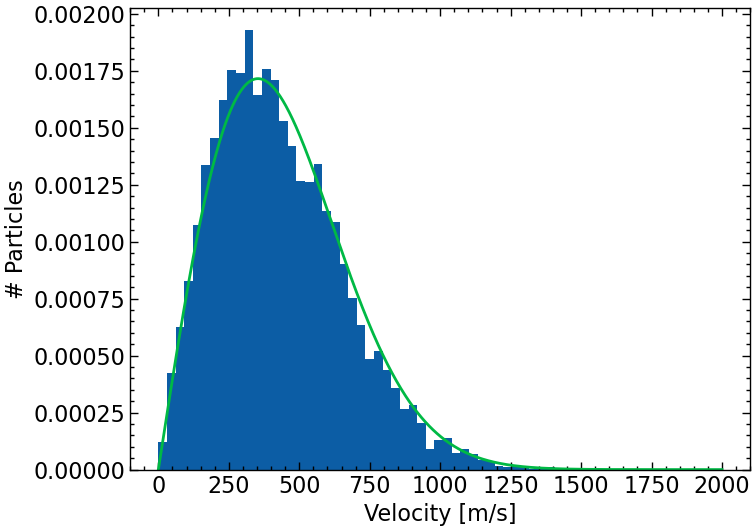

In [61]:
bins = np.linspace(0, 1500, 50)
plt.figure()
plt.hist(torch.sqrt(torch.sum(vs[400]**2, axis=0)).cpu(), bins=bins, density=True)
# sum of the squares at the 400th time point, getting the magnitude of the speed
plt.plot(v, fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')

Finally, we can make an animation of the particles moving around and the histogram at the same time

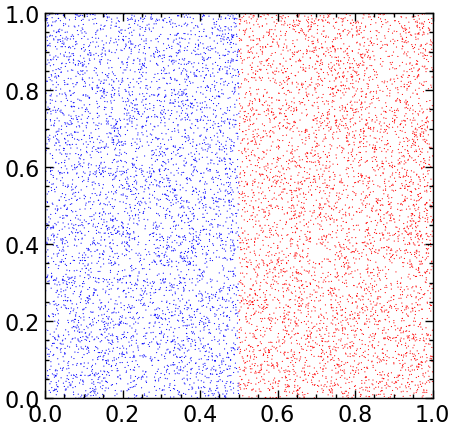

In [63]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl], rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred, yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue, yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

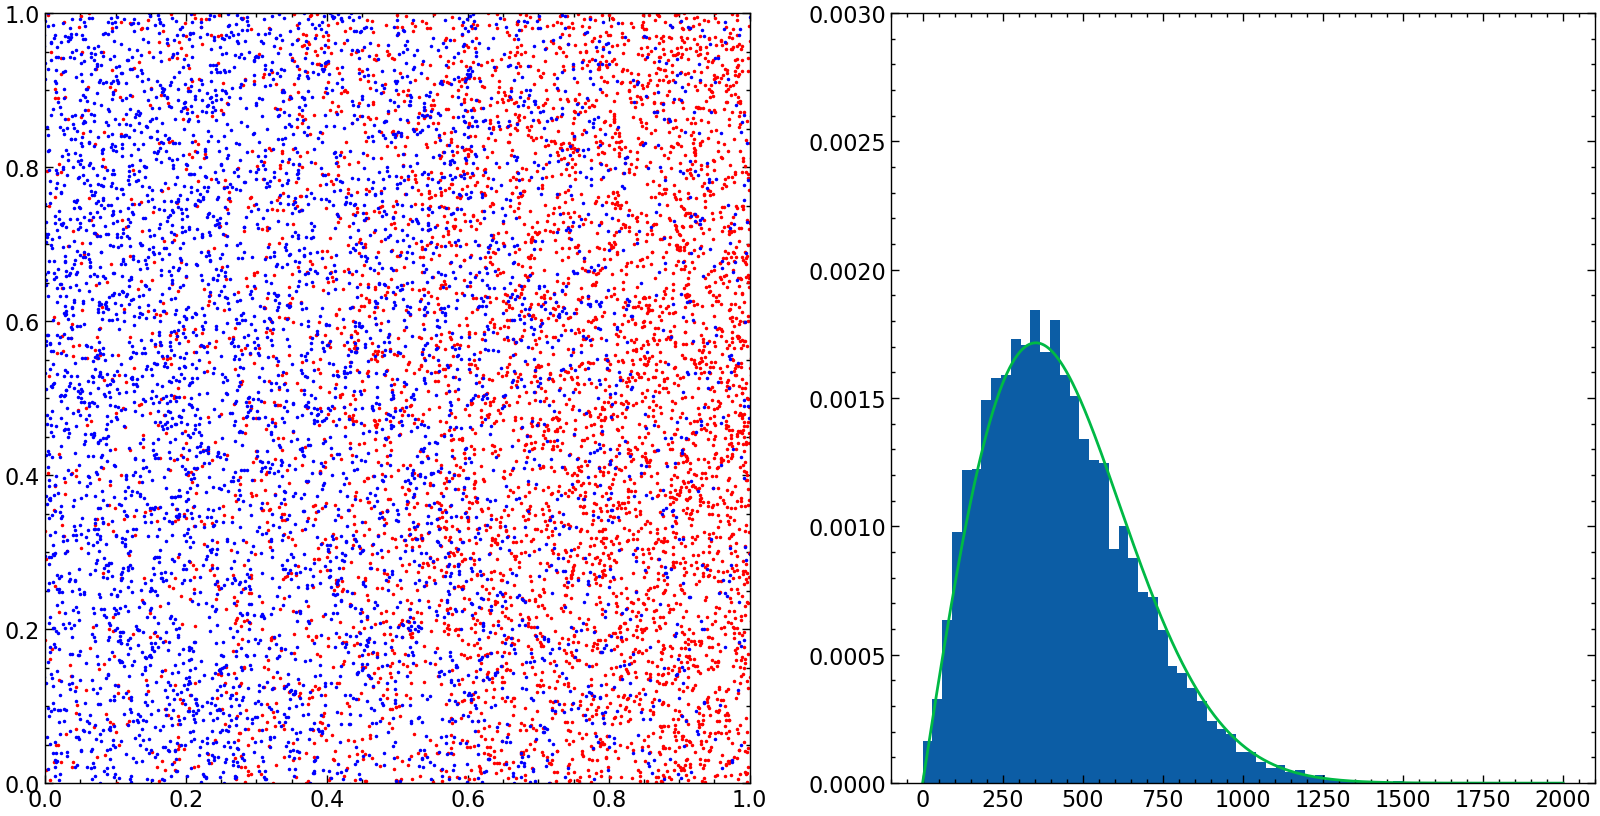

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].clear()
vmin = 0
vmax = 1
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
markersize = 2*radius *axes[0].get_window_extent().width / (vmax-vmin) *72./fig.dpi
red, = axes[0].plot([], [], 'o', color='red', markersize=markersize)
blue, = axes[0].plot([], [], 'o', color='blue', markersize=markersize)
n, bins, patches = axes[1].hist(torch.sqrt(torch.sum(vs[0]**2, axis=0)).cpu(), bins=bins, density=True)
axes[1].plot(v, fv)
axes[1].set_ylim(top=0.003)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(), rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    
    hist, _ = np.histogram(torch.sqrt(torch.sum(vs[i]**2, axis=0)).cpu(), bins=bins, density=True)
    for i, patch in enumerate(patches):
        patch.set_height(hist[i])
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani_gpu_10000.mp4', writer=writer, dpi=100)